In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [ ]:
# LSTM 코드 작성 시 GPT의 도움을 받았습니다.
file_path = 'KS200_C_non값없.xlsx'
df = pd.read_excel(file_path)

# 옵션 pricing에 필요한 변수들
columns = ['Volume','sigma', 'k', 's', 'r', 't', 'Close']
data = df[columns]

# LSTM에 필요한 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# LSTM에 넣을 input 데이터의 길이를 정하고, y값(target)을 반환하는 함수
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length]) # sequence_length만큼 input데이터를 나눈다. i시점부터 i+sequence_length시점까지의 데이터가 input이 됨
        targets.append(data[i + sequence_length, columns.index('Close')]) # i+sequence_length시점의 실제 옵션 가격
    return np.array(sequences), np.array(targets)

sequence_length = 10  # LSTM input데이터의 길이
X, y = create_sequences(scaled_data, sequence_length) # feature와 target을 LSTM input에 넣을 수 있는 형태로 나누기

# train, test로 데이터 쪼개기
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM을 위한 파라미터들
input_size = len(columns) # t시점에 LSTM에 입력되는 input의 차원
hidden_size = 50 # hidden-state의 차원. 숫자가 작으면 성능이 낮고, 높으면 과적합 문제가 발생해 test에서 별로다
output_size = 1
learning_rate = 0.0001
num_epochs = 50
batch_size = 32

# LSTM모델 생성
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

# LSTM모델에 넣을 데이터 생성을 위한 object
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    # DataLoader가 dataset을 batch 단위로 나눌 때 dataset의 길이를 알아야하므로 이 메소드를 통해 데이터셋의 전체 크기를 파악
    def __len__(self):
        return len(self.sequences)

    # DataLoader가 batch 단위로 데이터 로드할 때, 각 batch에 포함될 target값과 feature값을 이 메소드를 통해 접근
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# 학습에 필요한 dataset 생성
train_dataset = TimeSeriesDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TimeSeriesDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# 학습에 필요한 dataset을 불러오고 batch 단위로 나누고 그렇게 나뉜 데이터들을 iterate 하여 학습시키기 위한 객체 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM, 손실함수, optimizer 초기화
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# LSTM 학습
for epoch in range(num_epochs):
    model.train()
    for sequences, targets in train_loader: # 학습데이터 출력
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets.unsqueeze(1)) # 위에 정의한 손실함수
        loss.backward()
        optimizer.step() # 파라미터 업데이트
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for sequences, targets in test_loader:
        outputs = model(sequences)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

# 정규화된 값을 원래의 스케일로 다시 변환
predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), data.shape[1]-1)), np.array(predictions).reshape(-1, 1)), axis=1))[:, -1]
actuals = scaler.inverse_transform(np.concatenate((np.zeros((len(actuals), data.shape[1]-1)), np.array(actuals).reshape(-1, 1)), axis=1))[:, -1]

# 실제값, 예측값 df생성
comparison = pd.DataFrame({'Actual': actuals, 'LSTM Prediction': predictions})

###########
# 앙상블 #
###########

# 데이터로드
file_path = 'KS200_C_non값없.xlsx'
df = pd.read_excel(file_path)
df = df.dropna()

X = df[['Volume', 'sigma', 'k', 't', 'r', 's']]
y = df['Close']

# test, train set 쪼개기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(0.7 * len(X)), random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 앙상블에 쓰일 모델들의 객체 생성 / 두 모델 모두 트리의 수가 100개, 트리는 모두 Decision tree
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # 100개의 서로 다른 예측을 평균한다
xgb_model = XGBRegressor(n_estimators=100, random_state=42) # 순차적으로 예측된 100개의 값들을 순서대로 보정


# RandomForest, XGBoost 훈련
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)

# 각각의 모델들을 통해 옵션가격 예측
rf_predictions = rf_model.predict(X_test_scaled)
xgb_predictions = xgb_model.predict(X_test_scaled)

# 각 모델의 결과값들을 평균내는 식으로 앙상블 구성
ensemble_predictions = (rf_predictions + xgb_predictions) / 2

# 실제값, 앙상블의 예측값 dataframe 생성
results_df = pd.DataFrame({
    'Actual Value': y_test.reset_index(drop=True),
    'Ensemble Prediction': ensemble_predictions
})

Epoch [10/50], Loss: 0.0057
Epoch [20/50], Loss: 0.0007
Epoch [30/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0005
Epoch [50/50], Loss: 0.0005


In [ ]:
# LSTM의 예측값들을 담은 comparison과 ensemble의 예측값들과 하나의 dataframe으로 합치기
comparison['Ensemble Prediction'] = results_df['Ensemble Prediction']

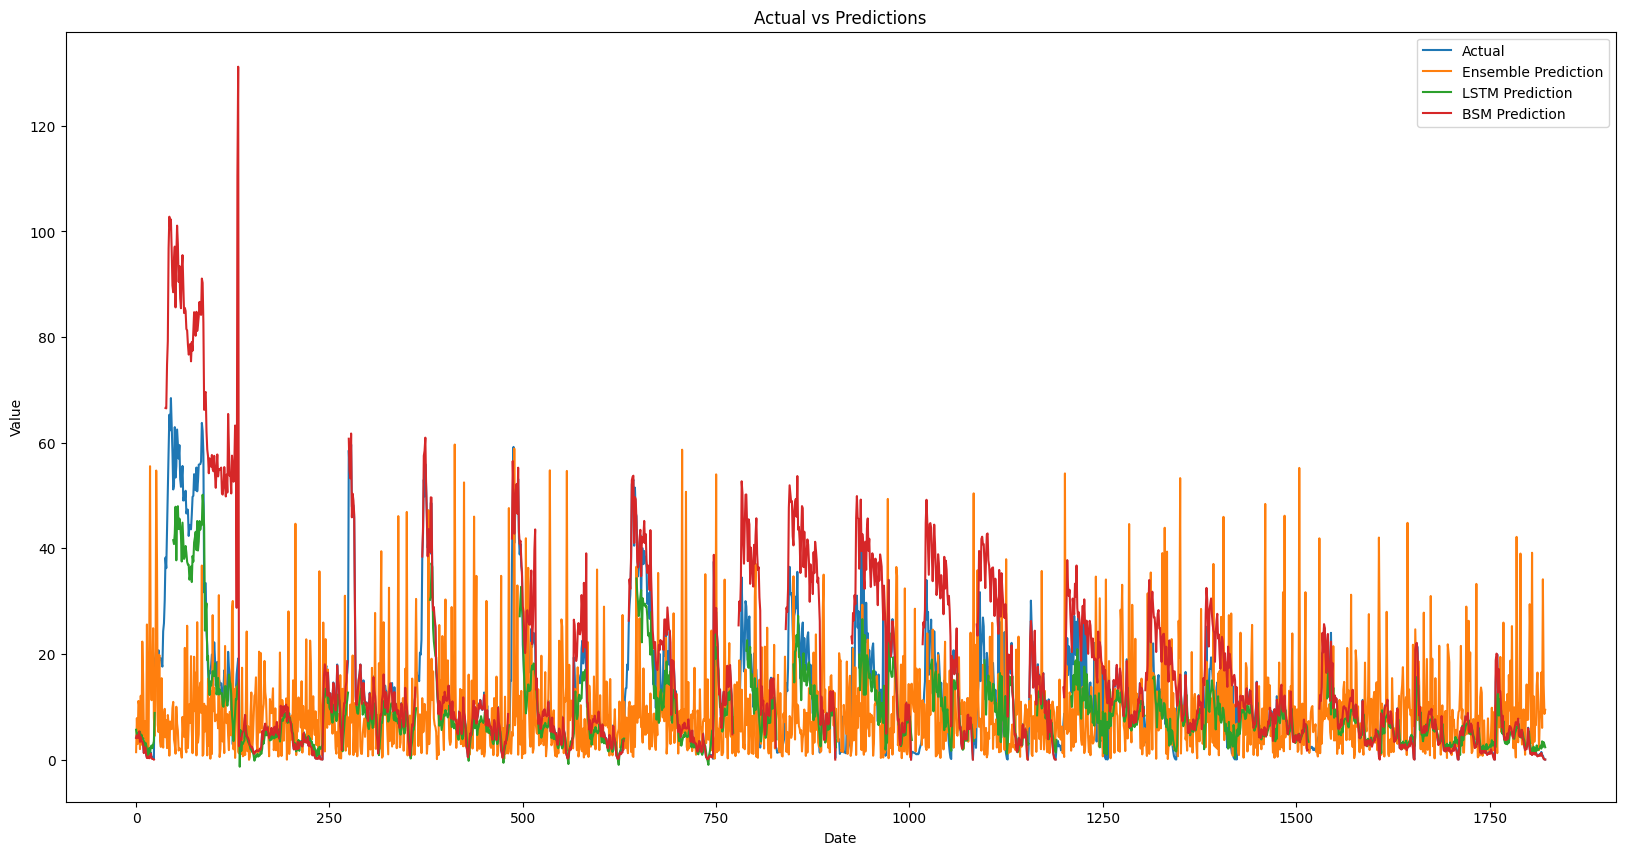

In [ ]:
file_path = 'KS200_C_non값없.xlsx'
df = pd.read_excel(file_path)

bsm = df['Option Price']
bsm = bsm.iloc[-len(comparison):].reset_index(drop=True)
actual = comparison['Actual']
ensemble_prediction = comparison['Ensemble Prediction']
lstm_prediction = comparison['LSTM Prediction']


# 플롯 크기 설정
plt.figure(figsize=(20, 10))

plt.plot(comparison.index, actual, label='Actual')
plt.plot(comparison.index, ensemble_prediction, label='Ensemble Prediction')
plt.plot(comparison.index, lstm_prediction, label='LSTM Prediction')
plt.plot(comparison.index, bsm, label='BSM Prediction')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predictions')
plt.legend()

plt.show()

In [ ]:
# RMSE 출력
# rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
# xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
ensemble_rmse = mean_squared_error(y_test, ensemble_predictions, squared=False)
predictions_df = pd.DataFrame({'LSTM Prediction': predictions, 'Actual':actual})
predictions_df = predictions_df.dropna()
lstm_rmse = mean_squared_error(predictions_df['Actual'], predictions_df['LSTM Prediction'], squared=False)
file_path = 'KS200_C_non값없.xlsx'
df = pd.read_excel(file_path)
df = df.dropna()
bs_rmse = mean_squared_error(df['Close'], df['Option Price'], squared=False)

"""
RMSE(Root Mean Square Error) 결과 : 앙상블 모델의 성능이 제일 좋다.
이 예측에서 만기까지의 남은 일수는 사용하였지만 실제 시간의 순서를 고려하지 않았다. 각 개별 시점의 행사가에 대한 가격을 예측 한 것이지, 옵션가격의 변화를 시간의 흐름에 따라 엄밀히 따진 것이 아니므로
시간의 흐름을 고려하는 LSTM모델이 앙상블보다 결과가 안 좋게 나온 것이다.
위의 표에서도 Date는 0시점부터 1750시점까지의 전체적인 시간흐름을 표현한 것이 아닌, 각각의 행사가에 해당하는 시간의 구간이 여러 개로 나뉜 것인다.
"""
#print(f"Random Forest RMSE: {np.sqrt(rf_rmse)}")
#print(f"XGBoost RMSE: {np.sqrt(xgb_rmse)}")
print(f"Ensemble RMSE: {np.sqrt(ensemble_rmse)}")
print(f"LSTM RMSE: {np.sqrt(lstm_rmse)}")
print(f"BS RMSE: {np.sqrt(bs_rmse)}")

Ensemble RMSE: 1.588648611977469
LSTM RMSE: 2.1328006950045055
BS RMSE: 3.4842403153918733


In [ ]:
# https://github.com/Pradnya1208/Time-series-forecasting-using-Deep-Learning/blob/main/deep_learning_for_time_series_forecasting.ipynb
# https://github.com/0aqz0/SLR
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_shape):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=1)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=1)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()

        # LSTM part
        self.lstm_input_size = self._get_conv_output(input_shape)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=128, batch_first=True)
        self.dropout3 = nn.Dropout(0.25)

        # Fully connected layer
        self.fc1 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.25)

        # Output layer
        self.fc2 = nn.Linear(64, 1)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = self.flatten(x)
        x = x.view(x.size(0), -1, self.lstm_input_size)  # Reshape for LSTM input
        x, (h_n, c_n) = self.lstm(x)
        x = self.dropout3(x[:, -1, :])
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

# Load the data
input_data = pd.read_excel("/content/KS200_C_non값없.xlsx")
columns = ['Volume','sigma', 'k', 's', 'r', 't', 'Close']
input_data = input_data[columns]
# Assuming the target variable is in the last column
X = input_data.iloc[:, :-1].values
X_df = pd.DataFrame(X)
X_df = X_df.dropna()
X = X_df.values
y = input_data.iloc[:X.shape[0], -1].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data to fit the input shape of Conv1D
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
input_shape = (1, X_train.shape[2])
model = CNN_LSTM_Model(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with gradient clipping
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

# Evaluate the model
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        all_predictions.extend(outputs.numpy())
        all_targets.extend(y_batch.numpy())

Epoch 1/50, Loss: 79.50851958592733
Epoch 2/50, Loss: 44.571118450164796
Epoch 3/50, Loss: 38.050728963216145
Epoch 4/50, Loss: 37.91335721651713
Epoch 5/50, Loss: 35.20075937906901
Epoch 6/50, Loss: 36.26605082511902
Epoch 7/50, Loss: 34.25834494272868
Epoch 8/50, Loss: 34.17679378827413
Epoch 9/50, Loss: 34.99232378482819
Epoch 10/50, Loss: 33.66416317303975
Epoch 11/50, Loss: 35.175458132425945
Epoch 12/50, Loss: 32.94710881630579
Epoch 13/50, Loss: 33.65991648991903
Epoch 14/50, Loss: 33.0608426729838
Epoch 15/50, Loss: 32.08515645345052
Epoch 16/50, Loss: 31.685311732292174
Epoch 17/50, Loss: 32.77080149968465
Epoch 18/50, Loss: 32.303912455240884
Epoch 19/50, Loss: 31.625262053807578
Epoch 20/50, Loss: 31.375974283218383
Epoch 21/50, Loss: 31.463540240923564
Epoch 22/50, Loss: 31.988631315231324
Epoch 23/50, Loss: 31.290142374038695
Epoch 24/50, Loss: 31.905097306569417
Epoch 25/50, Loss: 31.62524528503418
Epoch 26/50, Loss: 32.67311892350515
Epoch 27/50, Loss: 30.720029241244
Ep

In [ ]:
# Convert lists to numpy arrays for easier comparison
all_predictions = np.array(all_predictions).flatten()
all_targets = np.array(all_targets).flatten()

# Print the predictions and the actual values
print("Predictions: ", all_predictions)
print("Actual Values: ", all_targets)

# Optionally, calculate MSE on the test set
test_mse = ((all_predictions - all_targets) ** 2).mean()

Predictions:  [ 1.4543626  7.7762074  2.9006598 ... 10.392361   6.2626524  3.4188364]
Actual Values:  [ 1.41  7.    4.35 ... 12.65  7.05  3.77]
Test MSE: 5.580855846405029


In [ ]:
#print(f"Random Forest RMSE: {np.sqrt(rf_rmse)}")
#print(f"XGBoost RMSE: {np.sqrt(xgb_rmse)}")
print(f"Ensemble RMSE: {np.sqrt(ensemble_rmse)}")
print(f"LSTM RMSE: {np.sqrt(lstm_rmse)}")
print(f"BS RMSE: {np.sqrt(bs_rmse)}")
print(f'Test MSE: {np.sqrt(test_mse)}')

NameError: name 'ensemble_rmse' is not defined

In [ ]:
# conv가 한 개인 경우보다 성능 더 안 좋음
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_shape, lstm_hidden_size=128, lstm_num_layers=1):
        super(CNN_LSTM_Model, self).__init__()

        self.ch1, self.ch2, self.ch3, self.ch4 = 64, 128, 256, 512
        self.k1, self.k2, self.k3, self.k4 = 1, 1, 1, 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.ch1, kernel_size=self.k1),
            nn.BatchNorm1d(self.ch1, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch1, out_channels=self.ch1, kernel_size=self.k1),
            nn.MaxPool1d(kernel_size=1),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=self.ch1, out_channels=self.ch2, kernel_size=self.k2),
            nn.BatchNorm1d(self.ch2, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch2, out_channels=self.ch2, kernel_size=1),
            nn.MaxPool1d(kernel_size=1),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=self.ch2, out_channels=self.ch3, kernel_size=self.k3),
            nn.BatchNorm1d(self.ch3, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch3, out_channels=self.ch3, kernel_size=1),
            nn.MaxPool1d(kernel_size=1),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=self.ch3, out_channels=self.ch4, kernel_size=self.k4),
            nn.BatchNorm1d(self.ch4, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch4, out_channels=self.ch4, kernel_size=1),
            nn.AdaptiveAvgPool1d(1),
        )

        self.lstm_input_size = self.ch4
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(lstm_hidden_size, 64)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        batch_size, _, sequence_length = x.size()
        cnn_embed_seq = []
        for t in range(sequence_length):
            out = self.conv1(x[:, :, t:t+1])
            out = self.conv2(out)
            out = self.conv3(out)
            out = self.conv4(out)
            out = out.view(batch_size, -1)
            cnn_embed_seq.append(out)

        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=1)

        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(cnn_embed_seq)
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# 데이터 불러오기 및 전처리
input_data = pd.read_excel("/content/KS200_C_non값없.xlsx")
columns = ['Volume','sigma', 'k', 's', 'r', 't', 'Close']
input_data = input_data[columns]
X = input_data.iloc[:, :-1].values
X_df = pd.DataFrame(X)
X_df = X_df.dropna()
X = X_df.values
y = input_data.iloc[:X.shape[0], -1].values

# 데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Conv1D 입력 형식에 맞게 데이터 재구성
X = X.reshape((X.shape[0], 1, X.shape[1]))

# 데이터셋을 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 초기화, 손실 함수 및 옵티마이저 설정
input_shape = (1, X_train.shape[2])
model = CNN_LSTM_Model(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

# 모델 평가
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        all_predictions.extend(outputs.numpy())
        all_targets.extend(y_batch.numpy())

Epoch 1/50, Loss: 100.2203689066569
Epoch 2/50, Loss: 88.35816809336345
Epoch 3/50, Loss: 81.87410852432251
Epoch 4/50, Loss: 71.98312227884928
Epoch 5/50, Loss: 64.98654736836751
Epoch 6/50, Loss: 60.300495891571046
Epoch 7/50, Loss: 57.63528979619344
Epoch 8/50, Loss: 55.560445098876954
Epoch 9/50, Loss: 52.49025904973348
Epoch 10/50, Loss: 52.96217684427897
Epoch 11/50, Loss: 49.20123427708943
Epoch 12/50, Loss: 54.31798268636068
Epoch 13/50, Loss: 51.53131217956543
Epoch 14/50, Loss: 49.57307977040609
Epoch 15/50, Loss: 51.12757133483887
Epoch 16/50, Loss: 55.715266914367675
Epoch 17/50, Loss: 50.384411792755124
Epoch 18/50, Loss: 48.849101333618165
Epoch 19/50, Loss: 46.57919178009033
Epoch 20/50, Loss: 46.72279825846354
Epoch 21/50, Loss: 46.16636216481527
Epoch 22/50, Loss: 45.71507474263509
Epoch 23/50, Loss: 43.26573762257894
Epoch 24/50, Loss: 43.315236536661786
Epoch 25/50, Loss: 43.167042325337725
Epoch 26/50, Loss: 42.046892890930174
Epoch 27/50, Loss: 42.519486287434894
E

In [ ]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_shape, lstm_hidden_size=128, lstm_num_layers=1):
        super(CNN_LSTM_Model, self).__init__()

        self.ch1, self.ch2, self.ch3, self.ch4 = 64, 128, 256, 512
        self.k1, self.k2, self.k3, self.k4 = 1, 1, 1, 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.ch1, kernel_size=self.k1),
            nn.BatchNorm1d(self.ch1, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch1, out_channels=self.ch1, kernel_size=self.k1),
            nn.MaxPool1d(kernel_size=1),
            nn.Dropout(0.5),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=self.ch1, out_channels=self.ch2, kernel_size=self.k2),
            nn.BatchNorm1d(self.ch2, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch2, out_channels=self.ch2, kernel_size=1),
            nn.MaxPool1d(kernel_size=1),
            nn.Dropout(0.5),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=self.ch2, out_channels=self.ch3, kernel_size=self.k3),
            nn.BatchNorm1d(self.ch3, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch3, out_channels=self.ch3, kernel_size=1),
            nn.MaxPool1d(kernel_size=1),
            nn.Dropout(0.5),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=self.ch3, out_channels=self.ch4, kernel_size=self.k4),
            nn.BatchNorm1d(self.ch4, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=self.ch4, out_channels=self.ch4, kernel_size=1),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(0.5),
        )

        self.lstm_input_size = self.ch4
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(lstm_hidden_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        batch_size, _, sequence_length = x.size()
        cnn_embed_seq = []
        for t in range(sequence_length):
            out = self.conv1(x[:, :, t:t+1])
            out = self.conv2(out)
            out = self.conv3(out)
            out = self.conv4(out)
            out = out.view(batch_size, -1)
            cnn_embed_seq.append(out)

        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=1)

        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(cnn_embed_seq)
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# 데이터 불러오기 및 전처리
input_data = pd.read_excel("/content/KS200_C_non값없.xlsx")
columns = ['Volume','sigma', 'k', 's', 'r', 't', 'Close']
input_data = input_data[columns]
X = input_data.iloc[:, :-1].values
X_df = pd.DataFrame(X)
X_df = X_df.dropna()
X = X_df.values
y = input_data.iloc[:X.shape[0], -1].values

# 데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Conv1D 입력 형식에 맞게 데이터 재구성
X = X.reshape((X.shape[0], 1, X.shape[1]))

# 데이터셋을 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 초기화, 손실 함수 및 옵티마이저 설정
input_shape = (1, X_train.shape[2])
model = CNN_LSTM_Model(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

# 모델 평가
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        all_predictions.extend(outputs.numpy())
        all_targets.extend(y_batch.numpy())

Epoch 1/50, Loss: 98.05481165568034
Epoch 2/50, Loss: 89.33231688181559
Epoch 3/50, Loss: 85.81082021077474
Epoch 4/50, Loss: 81.85138783772787
Epoch 5/50, Loss: 76.53136608123779
Epoch 6/50, Loss: 72.98484207153321
Epoch 7/50, Loss: 72.55909926096598
Epoch 8/50, Loss: 68.62645203908285
Epoch 9/50, Loss: 64.96224844614665
Epoch 10/50, Loss: 64.86250741322836
Epoch 11/50, Loss: 63.56617310841878
Epoch 12/50, Loss: 57.96362237294515
Epoch 13/50, Loss: 59.519057814280195
Epoch 14/50, Loss: 56.582625789642336
Epoch 15/50, Loss: 56.29566796620687
Epoch 16/50, Loss: 54.91553676605225
Epoch 17/50, Loss: 54.169376583099364
Epoch 18/50, Loss: 52.49794595082601
Epoch 19/50, Loss: 52.89617846171061
Epoch 20/50, Loss: 50.69983260790507
Epoch 21/50, Loss: 51.18758874893189
Epoch 22/50, Loss: 50.087829964955645
Epoch 23/50, Loss: 51.016581026713055
Epoch 24/50, Loss: 53.0126966603597
Epoch 25/50, Loss: 50.857119166056314
Epoch 26/50, Loss: 50.35508846282959
Epoch 27/50, Loss: 49.15888497034709
Epoch